<font size ="4">**Importing all the libraries**</font>

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import re
import nltk
import os
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [ ]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [3]:
fake_data = pd.read_csv('data/Fake.csv')
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_data = pd.read_csv("data/True.csv")
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Assigning Classes to the Dataset

In [5]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [6]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

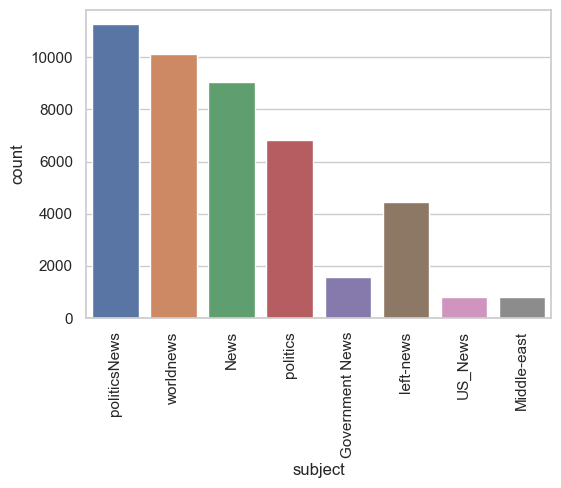

In [7]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [8]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [9]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [10]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [11]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [12]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,POLITICO DOWNGRADES AMERICA: Declares Germany’...,0
1,PHONY HILLARY PULLS THE WOMAN CARD AT JAY-Z/BE...,0
2,‘MR FAST AND FURIOUS’ ERIC HOLDER Destroyed on...,0
3,CLINTON SUPPORTER CARL BERNSTEIN : FBI Found A...,0
4,BILL O’REILLY ASKS TRUMP “Racist” Question Tha...,0


Now Let’s explore the unique values in the each category using below code.

<AxesSubplot:xlabel='label', ylabel='count'>

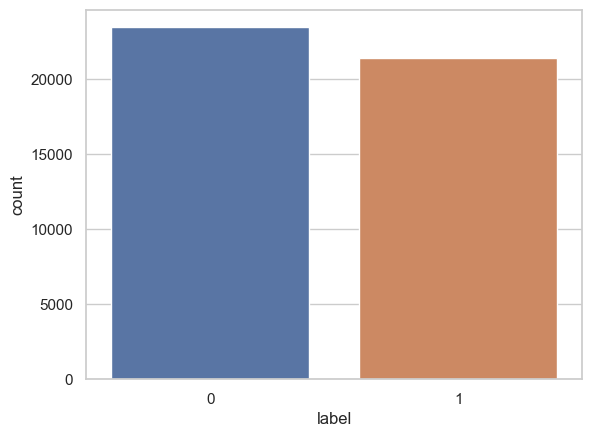

In [13]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [14]:
def preprocess_text(text):
    text=text.lower()#Text to lowercase
    text=re.sub('\[.*?\]'," ",text)#Content within square brackets are replaced
    text=re.sub('\W'," ",text)#Non alpha numeric characters are replaced
    text=re.sub('https?://\S+|www.\.\S+'," ",text)#URL starting with https/http/www are replaced
    text=re.sub('<.*?>'," ",text)#html tags are replaced
    text=re.sub('[0-9]'," ",text)#Numbers are replaced
    text=re.sub('\n'," ",text)#Newline characters are replaced
    text=re.sub('[%s]'% re.escape(string.punctuation)," ",text)#Punctuation characters are removed
    return text
data['text'] = data['text'].apply(preprocess_text)

In [15]:
x=data['text']
y=data['label']

In [16]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25)

<font size="4">**Converting text into Vectors**</font>

In [17]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf=TfidfVectorizer()
xv_train=Tfidf.fit_transform(x_train)
xv_test=Tfidf.transform(x_test)


<font size="4">**Model training, Evaluation, and Prediction**</font>

In [18]:
#TODO: Model training and print the accuracy score 
LR=LogisticRegression()
LR.fit(xv_train,y_train)
LR_prediction=LR.predict(xv_test)
accuracy=accuracy_score(y_test,LR_prediction)
print(accuracy)

0.9883296213808463


Classification Report
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5869
           1       0.99      0.99      0.99      5356

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

Confusion Matrix
 [[5807   62]
 [  69 5287]]


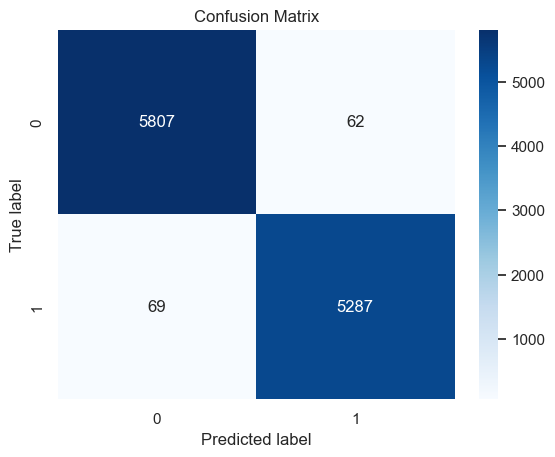

In [24]:
# Display the Confusion matrix of Results from your classification algorithm
from sklearn.metrics import classification_report,confusion_matrix
print("Classification Report\n",classification_report(y_test,LR_prediction))
print("Confusion Matrix\n",confusion_matrix(y_test,LR_prediction))
cm=confusion_matrix(y_test,LR_prediction)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [25]:
def output_label(n):
    if n==0:
        return "Fake News"
    elif n==1:
        return "Not a Fake news"
    
def testing(news):
    testnews={"text":[news]}
    df_test=pd.DataFrame(testnews)
    df_xtest=df_test["text"].apply(preprocess_text)
    df_xvtest=Tfidf.transform(df_xtest)
    Pred=LR.predict(df_xvtest)
    
    print("\n\nLogistic Regression Prediction",format(output_label(Pred[0])))
    

In [26]:
news=str(input())
testing(news)

Ukraine's Zelensky says the most intense fighting is happening on the southern front From CNN staff  Ukrainian President Volodymyr Zelensky says the toughest fighting is taking place on Ukraine’s southern front, and he praised Kyiv's forces for holding off Russian assaults in the east.  Zelensky made the comments in his daily address Sunday, saying Ukrainian troops are “advancing, position by position, step by step” and “are moving forward.”   The opening stages of Kyiv's counteroffensive have been marked by probing attacks — seemingly testing the Russian lines of defense — and modest gains, but no apparent major breakthroughs.   Russian troops "continue to focus their main efforts on the Lyman, Bakhmut, Avdiivka and Marinka directions," the Ukrainian military's General Staff said Sunday, referring to a series of eastern Ukrainian frontline cities stretching from north to south. "Heavy fighting continues."  Zelensky said that not a single US Patriot air defense system has been destroye

In [27]:
news=str(input())
testing(news)

 News outlets around the world are reporting on the news that Pope Francis has made the unprecedented decision to endorse a US presidential candidate. His statement in support of Donald Trump was released from the Vatican this evening:  “I have been hesitant to offer any kind of support for either candidate in the US presidential election but I now feel that to not voice my concern would be a dereliction of my duty as the Holy See. A strong and free America is vitally important in maintaining a strong and free world and in that sense what happens in American elections affects us all. The Rule of Law is the backbone of the American government as it is in any nation that strives for freedom and I now fear that the Rule of Law in America has been dealt a dangerous blow. The FBI, in refusing to recommend prosecution after admitting that the law had been broken on multiple occasions by Secretary Clinton, has exposed itself as corrupted by political forces that have become far too powerful. 